# Imports necessários

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from dotenv import load_dotenv
import os
from sqlalchemy import create_engine
import datetime as dt

# Conexão com o DB local

In [2]:
load_dotenv()

driver = os.environ["Driver"]
server = os.environ["Server"]
database = os.environ["Database"]

In [3]:
dados_conexao = (
    f"Driver={driver};"
    f"Server={server};"
    f"Database={database};"
)

In [4]:
def query_banco(query, dados_conexao):
    engine = create_engine(f'mssql+pyodbc:///?odbc_connect={dados_conexao}')
    return pd.read_sql(query, engine)

# Import dos dados

In [5]:
df_receitas = query_banco("SELECT * FROM Fato_Receita", dados_conexao)
df_receitas.drop(columns=['id','uid_fato_receita'], inplace=True)
df_receitas.rename(columns={'valor':'valor_receita'}, inplace=True)
df_receitas.head()

,cod_receita,data_fato,contribuinte_receita,valor_receita
0,1722010101,2013-01-03,886cd0eabf5a18,185560.68
1,1722010101,2013-01-04,886cd0eabf5a18,8081.80
2,1722010101,2013-01-07,886cd0eabf5a18,4231.39
3,1722010101,2013-01-08,886cd0eabf5a18,10536.53
4,1722010101,2013-01-15,886cd0eabf5a18,103118.27


In [6]:
df_populacao = query_banco("SELECT * FROM Dim_Populacao", dados_conexao)
df_populacao.drop(columns=['id'], inplace=True)
df_populacao

,ano,populacao,variacao_anual,porcentagem_variacao_anual,aceleracao_variacao_anual,porcentagem_aceleracao_variacao_anual
0,1991,51273,0,0,0,0
1,1992,51530,257,"0,5",0,0
2,1993,51965,435,"0,84",178,"69,26"
3,1994,52279,314,"0,6",-121,"-27,82"
4,1995,52586,307,"0,59",-7,"-2,23"
5,1996,51396,-1190,"-2,26",-1497,"-487,62"
6,1997,51575,179,"0,35",1369,"-115,04"
7,1998,51726,151,"0,29",-28,"-15,64"
8,1999,51878,152,"0,29",1,"0,66"
9,2000,54715,2837,"5,47",2685,"1766,45"


In [7]:
df_pib = query_banco("SELECT * FROM Dim_PIB", dados_conexao)
df_pib.drop(columns=['id'], inplace=True)
df_pib.rename(columns={'valor':'valor_pib'}, inplace=True)
df_pib

,ano,valor_pib
0,2006-01-01,342557000
1,2008-01-01,449804000
2,2010-01-01,545321000
3,2012-01-01,688504000
4,2014-01-01,904648000
5,2016-01-01,1039264000
6,2018-01-01,1064232000
7,2020-01-01,1134471000
8,2006-01-01,342557
9,2008-01-01,449804


# Feature engineering

## Inserindo colunas que tratam do tempo

In [8]:
def cria_colunas_tempo(df, coluna_data):
    df[coluna_data] = pd.to_datetime(df[coluna_data])
    df['ano_mes'] = df[coluna_data].dt.strftime('%Y-%m')
    df['ano'] = df[coluna_data].dt.strftime('%Y')
    return df

def transforma_data_em_ordinal(df, coluna_referencia):
    df['ano_mes_ordinal'] = pd.to_datetime(df[coluna_referencia])
    df['ano_mes_ordinal'] = df['ano_mes_ordinal'].map(dt.datetime.toordinal)
    return df

def transforma_coluna_em_datetime(df, coluna):
    df[coluna] = pd.to_datetime(df[coluna], format='%Y')
    return df

## Remoção de outliers

In [9]:
# Aplicação de IQR - Interquartile Range
def remove_outliers(df, coluna):
    Q1 = df[coluna].quantile(0.25)
    print(f'Q1: {Q1}')
    Q3 = df[coluna].quantile(0.75)
    print(f'Q3: {Q3}')
    IQR = Q3 - Q1
    print(f'IQR: {IQR}')
    print(f'Limite inferior: {Q1 - 1.5 * IQR}')
    print(f'Limite superior: {Q3 + 1.5 * IQR}')
    df = df[(df[coluna] >= Q1 - 1.5*IQR) & (df[coluna] <= Q3 + 1.5*IQR)]
    print(f'Quantidade de registros sem outliers: {df.shape[0]}')
    return df

# Gráfico de dispersão
def box_plot(df, coluna_referencia, coluna_visao):
    print(f'Quantidade de registros: {df.shape[0]}')
    df.boxplot(by=coluna_referencia, column=coluna_visao, figsize=(10,6))

In [10]:
def plot_series_data(df, coluna_referencia):
    train_size = int(len(df) * 0.8)
    train_dataset, test_dataset = df.iloc[:train_size], df.iloc[train_size:]
    plt.figure(figsize=(20,10))
    plt.plot(train_dataset[coluna_referencia])
    plt.plot(test_dataset[coluna_referencia])
    plt.xlabel('Período')
    plt.ylabel('Valor Arrecadado')
    plt.legend(['Treino', 'Teste'], loc='upper left')
    plt.show()
    plt.savefig('../../src/static/images/dados_treinamento.png')
    print('Dimension of train data: ', train_dataset.shape)
    print('Dimension of test data: ', test_dataset.shape)

## Conversão de tipos de dados nas colunas

In [11]:
def converte_tipo_dados(df, colunas, tipo):
    for coluna in colunas:
        df[coluna] = df[coluna].astype(tipo)
    return df

# Análise exploratória dos dados

## Receitas

In [12]:
df_receitas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102293 entries, 0 to 102292
Data columns (total 4 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   cod_receita           102293 non-null  int64         
 1   data_fato             102293 non-null  datetime64[ns]
 2   contribuinte_receita  102293 non-null  object        
 3   valor_receita         102293 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 3.1+ MB


In [13]:
df_receitas.describe().round(2)

,cod_receita,data_fato,valor_receita
count,1.022930e+05,102293,102293.00
mean,1.256925e+09,2017-11-11 13:19:10.635918336,12522.46
min,1.112500e+08,2013-01-02 00:00:00,-2489288.55
25%,1.113034e+09,2015-07-16 00:00:00,51.23
50%,1.121250e+09,2017-10-13 00:00:00,240.60
75%,1.325000e+09,2020-02-05 00:00:00,1579.25
max,9.728013e+09,2022-12-30 00:00:00,4674330.00
std,1.162115e+09,NaN,89618.73


In [14]:
df_receitas_com_outliers = cria_colunas_tempo(df_receitas,'data_fato')
df_receitas_com_outliers.head()

,cod_receita,data_fato,contribuinte_receita,valor_receita,ano_mes,ano
0,1722010101,2013-01-03,886cd0eabf5a18,185560.68,2013-01,2013
1,1722010101,2013-01-04,886cd0eabf5a18,8081.80,2013-01,2013
2,1722010101,2013-01-07,886cd0eabf5a18,4231.39,2013-01,2013
3,1722010101,2013-01-08,886cd0eabf5a18,10536.53,2013-01,2013
4,1722010101,2013-01-15,886cd0eabf5a18,103118.27,2013-01,2013


Quantidade de registros: 102293


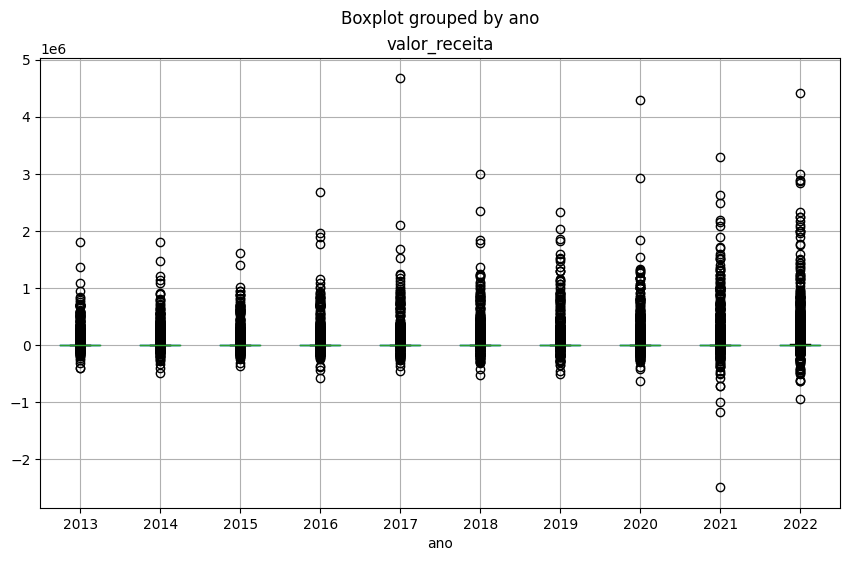

In [15]:
box_plot(df_receitas_com_outliers, 'ano', 'valor_receita')

In [16]:
df_receitas_sem_outliers = remove_outliers(df_receitas_com_outliers, 'valor_receita')

Q1: 51.23
Q3: 1579.25
IQR: 1528.02
Limite inferior: -2240.7999999999997
Limite superior: 3871.2799999999997
Quantidade de registros sem outliers: 83736


Quantidade de registros: 83736


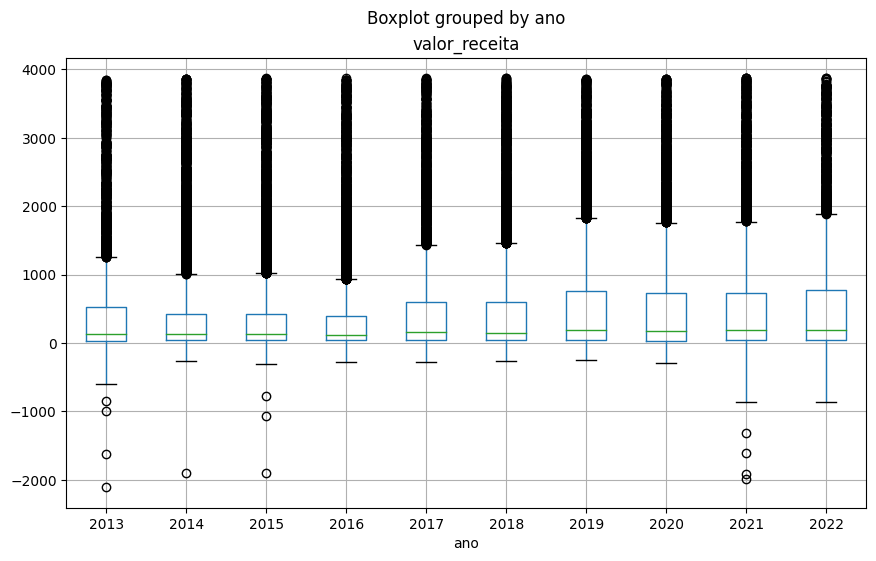

In [17]:
box_plot(df_receitas_sem_outliers, 'ano', 'valor_receita')

## População

In [18]:
df_populacao.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 6 columns):
 #   Column                                 Non-Null Count  Dtype 
---  ------                                 --------------  ----- 
 0   ano                                    32 non-null     int64 
 1   populacao                              32 non-null     int64 
 2   variacao_anual                         32 non-null     object
 3   porcentagem_variacao_anual             32 non-null     object
 4   aceleracao_variacao_anual              32 non-null     object
 5   porcentagem_aceleracao_variacao_anual  32 non-null     object
dtypes: int64(2), object(4)
memory usage: 1.6+ KB


In [19]:
df_populacao.describe().round(0)

,ano,populacao
count,32.0,32.0
mean,2006.0,57024.0
std,9.0,4073.0
min,1991.0,51273.0
25%,1999.0,52509.0
50%,2006.0,57065.0
75%,2014.0,61130.0
max,2022.0,63239.0


In [20]:
df_populacao_dados_copy = df_populacao.copy()
df_populacao_dados_convertidos = df_populacao_dados_copy
df_populacao_dados_convertidos['ano'] = df_populacao_dados_convertidos['ano'].astype(object)
df_populacao_dados_convertidos = transforma_coluna_em_datetime(df_populacao, 'ano')
df_populacao_dados_convertidos = cria_colunas_tempo(df_populacao, 'ano')
df_populacao_dados_convertidos['porcentagem_variacao_anual'] = df_populacao_dados_convertidos['porcentagem_variacao_anual'].str.replace(',','.').astype(float)
df_populacao_dados_convertidos['porcentagem_aceleracao_variacao_anual'] = df_populacao_dados_convertidos['porcentagem_aceleracao_variacao_anual'].str.replace(',','.').astype(float)

In [21]:
df_populacao_dados_convertidos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 7 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   ano                                    32 non-null     object 
 1   populacao                              32 non-null     int64  
 2   variacao_anual                         32 non-null     object 
 3   porcentagem_variacao_anual             32 non-null     float64
 4   aceleracao_variacao_anual              32 non-null     object 
 5   porcentagem_aceleracao_variacao_anual  32 non-null     float64
 6   ano_mes                                32 non-null     object 
dtypes: float64(2), int64(1), object(4)
memory usage: 1.9+ KB


In [22]:
df_populacao_dados_convertidos = converte_tipo_dados(df_populacao_dados_convertidos, ['variacao_anual', 'aceleracao_variacao_anual'], 'int64')
df_populacao_dados_convertidos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 7 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   ano                                    32 non-null     object 
 1   populacao                              32 non-null     int64  
 2   variacao_anual                         32 non-null     int64  
 3   porcentagem_variacao_anual             32 non-null     float64
 4   aceleracao_variacao_anual              32 non-null     int64  
 5   porcentagem_aceleracao_variacao_anual  32 non-null     float64
 6   ano_mes                                32 non-null     object 
dtypes: float64(2), int64(3), object(2)
memory usage: 1.9+ KB


In [23]:
df_populacao_dados_convertidos

,ano,populacao,variacao_anual,porcentagem_variacao_anual,aceleracao_variacao_anual,porcentagem_aceleracao_variacao_anual,ano_mes
0,1991,51273,0,0.00,0,0.00,1991-01
1,1992,51530,257,0.50,0,0.00,1992-01
2,1993,51965,435,0.84,178,69.26,1993-01
3,1994,52279,314,0.60,-121,-27.82,1994-01
4,1995,52586,307,0.59,-7,-2.23,1995-01
5,1996,51396,-1190,-2.26,-1497,-487.62,1996-01
6,1997,51575,179,0.35,1369,-115.04,1997-01
7,1998,51726,151,0.29,-28,-15.64,1998-01
8,1999,51878,152,0.29,1,0.66,1999-01
9,2000,54715,2837,5.47,2685,1766.45,2000-01


## PIB

In [24]:
df_pib.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ano        21 non-null     object
 1   valor_pib  21 non-null     object
dtypes: object(2)
memory usage: 468.0+ bytes


In [25]:
df_pib_convertidos = converte_tipo_dados(df_pib, ['valor_pib'], 'float')

In [26]:
# Estimar valores para os anos 2021 e 2022 usando a média das variações anuais
variacoes_anuais = df_pib_convertidos.groupby('ano')['valor_pib'].last().pct_change().mean()
valor_2020 = df_pib_convertidos['valor_pib'].values[-1]
valor_2021_estimado = valor_2020 * (1 + variacoes_anuais)
valor_2022_estimado = valor_2021_estimado * (1 + variacoes_anuais)

In [27]:
df_pib# Criar um novo DataFrame com as linhas para 2021 e 2022
novas_linhas = pd.DataFrame({'ano': [2021, 2022], 'valor_pib': [valor_2021_estimado, valor_2022_estimado]})
novas_linhas = transforma_coluna_em_datetime(novas_linhas, 'ano')

# Concatenar as novas linhas ao DataFrame original
df_pib_convertidos = pd.concat([df_pib_convertidos, novas_linhas], ignore_index=True)
df_pib_convertidos

,ano,valor_pib
0,2006-01-01,3.425570e+08
1,2008-01-01,4.498040e+08
2,2010-01-01,5.453210e+08
3,2012-01-01,6.885040e+08
4,2014-01-01,9.046480e+08
5,2016-01-01,1.039264e+09
6,2018-01-01,1.064232e+09
7,2020-01-01,1.134471e+09
8,2006-01-01,3.425570e+05
9,2008-01-01,4.498040e+05


In [28]:
df_pib_convertidos = cria_colunas_tempo(df_pib_convertidos, 'ano')

In [29]:
df_pib_convertidos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23 entries, 0 to 22
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ano        23 non-null     object 
 1   valor_pib  23 non-null     float64
 2   ano_mes    23 non-null     object 
dtypes: float64(1), object(2)
memory usage: 684.0+ bytes


In [30]:
df_pib_convertidos

,ano,valor_pib,ano_mes
0,2006,3.425570e+08,2006-01
1,2008,4.498040e+08,2008-01
2,2010,5.453210e+08,2010-01
3,2012,6.885040e+08,2012-01
4,2014,9.046480e+08,2014-01
5,2016,1.039264e+09,2016-01
6,2018,1.064232e+09,2018-01
7,2020,1.134471e+09,2020-01
8,2006,3.425570e+05,2006-01
9,2008,4.498040e+05,2008-01


# Preparo dos df para implementação dos modelos de RN

### Dados da receita + população + pib

In [31]:
df_receitas_sem_outliers.drop(columns=['cod_receita','contribuinte_receita'], inplace=True)
df_populacao_dados_convertidos.drop(columns=['porcentagem_variacao_anual', 'porcentagem_aceleracao_variacao_anual','ano_mes'], inplace=True)
df_pib_convertidos.drop(columns=['ano_mes'], inplace=True)

C:\Users\allys\AppData\Local\Temp\ipykernel_32476\3075247237.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_receitas_sem_outliers.drop(columns=['cod_receita','contribuinte_receita'], inplace=True)


In [32]:
df_receitas_agrupado = df_receitas_sem_outliers.groupby(['ano', 'ano_mes'])['valor_receita'].sum().reset_index()
df_receitas_agrupado = pd.merge(df_receitas_agrupado, df_populacao_dados_convertidos, on='ano', how='left')
df_receitas_agrupado = pd.merge(df_receitas_agrupado, df_pib_convertidos, on='ano', how='left')
df_receitas_agrupado

,ano,ano_mes,valor_receita,populacao,variacao_anual,aceleracao_variacao_anual,valor_pib
0,2013,2013-01,160122.33,60612,1482,1146,7.703390e+05
1,2013,2013-02,125630.52,60612,1482,1146,7.703390e+05
2,2013,2013-03,169281.06,60612,1482,1146,7.703390e+05
3,2013,2013-04,161371.68,60612,1482,1146,7.703390e+05
4,2013,2013-05,158982.66,60612,1482,1146,7.703390e+05
...,...,...,...,...,...,...,...
163,2022,2022-08,232355.13,63239,663,376,1.393869e+06
164,2022,2022-09,198234.65,63239,663,376,1.393869e+06
165,2022,2022-10,185469.57,63239,663,376,1.393869e+06
166,2022,2022-11,207671.22,63239,663,376,1.393869e+06


### Elaborando metadados

#### Sample dos dados

In [33]:
# sample dos dados para as receitas mensais do município
df_receitas_agrupado['SMA(12)'] = df_receitas_agrupado['valor_receita'].rolling(window=12).mean()
df_receitas_agrupado['SMA(6)'] = df_receitas_agrupado['valor_receita'].rolling(window=6).mean()
df_receitas_agrupado['SMA(3)'] = df_receitas_agrupado['valor_receita'].rolling(window=3).mean()
df_receitas_agrupado['SMA(2)'] = df_receitas_agrupado['valor_receita'].rolling(window=2).mean()
df_receitas_agrupado['lag(12)'] = df_receitas_agrupado['valor_receita'].shift(12)
df_receitas_agrupado['lag(6)'] = df_receitas_agrupado['valor_receita'].shift(6)
df_receitas_agrupado['lag(4)'] = df_receitas_agrupado['valor_receita'].shift(4)
df_receitas_agrupado['lag(3)'] = df_receitas_agrupado['valor_receita'].shift(3)
df_receitas_agrupado['lag(2)'] = df_receitas_agrupado['valor_receita'].shift(2)
df_receitas_agrupado['lag(1)'] = df_receitas_agrupado['valor_receita'].shift(1)
df_receitas_agrupado.head()

,ano,ano_mes,valor_receita,populacao,variacao_anual,aceleracao_variacao_anual,valor_pib,SMA(12),SMA(6),SMA(3),SMA(2),lag(12),lag(6),lag(4),lag(3),lag(2),lag(1)
0,2013,2013-01,160122.33,60612,1482,1146,770339.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013,2013-02,125630.52,60612,1482,1146,770339.0,NaN,NaN,NaN,142876.425,NaN,NaN,NaN,NaN,NaN,160122.33
2,2013,2013-03,169281.06,60612,1482,1146,770339.0,NaN,NaN,151677.97,147455.790,NaN,NaN,NaN,NaN,160122.33,125630.52
3,2013,2013-04,161371.68,60612,1482,1146,770339.0,NaN,NaN,152094.42,165326.370,NaN,NaN,NaN,160122.33,125630.52,169281.06
4,2013,2013-05,158982.66,60612,1482,1146,770339.0,NaN,NaN,163211.80,160177.170,NaN,NaN,160122.33,125630.52,169281.06,161371.68


In [34]:
df_receitas_agrupado['SMA(12)'].fillna(0, inplace=True)
df_receitas_agrupado['SMA(6)'].fillna(0, inplace=True)
df_receitas_agrupado['SMA(3)'].fillna(0, inplace=True)
df_receitas_agrupado['SMA(2)'].fillna(0, inplace=True)
df_receitas_agrupado['lag(12)'].fillna(0, inplace=True)
df_receitas_agrupado['lag(6)'].fillna(0, inplace=True)
df_receitas_agrupado['lag(4)'].fillna(0, inplace=True)
df_receitas_agrupado['lag(3)'].fillna(0, inplace=True)
df_receitas_agrupado['lag(2)'].fillna(0, inplace=True)
df_receitas_agrupado['lag(1)'].fillna(0, inplace=True)
df_receitas_agrupado.head()

,ano,ano_mes,valor_receita,populacao,variacao_anual,aceleracao_variacao_anual,valor_pib,SMA(12),SMA(6),SMA(3),SMA(2),lag(12),lag(6),lag(4),lag(3),lag(2),lag(1)
0,2013,2013-01,160122.33,60612,1482,1146,770339.0,0.0,0.0,0.00,0.000,0.0,0.0,0.00,0.00,0.00,0.00
1,2013,2013-02,125630.52,60612,1482,1146,770339.0,0.0,0.0,0.00,142876.425,0.0,0.0,0.00,0.00,0.00,160122.33
2,2013,2013-03,169281.06,60612,1482,1146,770339.0,0.0,0.0,151677.97,147455.790,0.0,0.0,0.00,0.00,160122.33,125630.52
3,2013,2013-04,161371.68,60612,1482,1146,770339.0,0.0,0.0,152094.42,165326.370,0.0,0.0,0.00,160122.33,125630.52,169281.06
4,2013,2013-05,158982.66,60612,1482,1146,770339.0,0.0,0.0,163211.80,160177.170,0.0,0.0,160122.33,125630.52,169281.06,161371.68


In [35]:
df_receitas_agrupado.drop(columns=['ano'], inplace=True)
df_receitas_agrupado = transforma_data_em_ordinal(df_receitas_agrupado, 'ano_mes')
df_receitas_agrupado.drop(columns=['ano_mes'], inplace=True)
df_receitas_agrupado.head()

,valor_receita,populacao,variacao_anual,aceleracao_variacao_anual,valor_pib,SMA(12),SMA(6),SMA(3),SMA(2),lag(12),lag(6),lag(4),lag(3),lag(2),lag(1),ano_mes_ordinal
0,160122.33,60612,1482,1146,770339.0,0.0,0.0,0.00,0.000,0.0,0.0,0.00,0.00,0.00,0.00,734869
1,125630.52,60612,1482,1146,770339.0,0.0,0.0,0.00,142876.425,0.0,0.0,0.00,0.00,0.00,160122.33,734900
2,169281.06,60612,1482,1146,770339.0,0.0,0.0,151677.97,147455.790,0.0,0.0,0.00,0.00,160122.33,125630.52,734928
3,161371.68,60612,1482,1146,770339.0,0.0,0.0,152094.42,165326.370,0.0,0.0,0.00,160122.33,125630.52,169281.06,734959
4,158982.66,60612,1482,1146,770339.0,0.0,0.0,163211.80,160177.170,0.0,0.0,160122.33,125630.52,169281.06,161371.68,734989


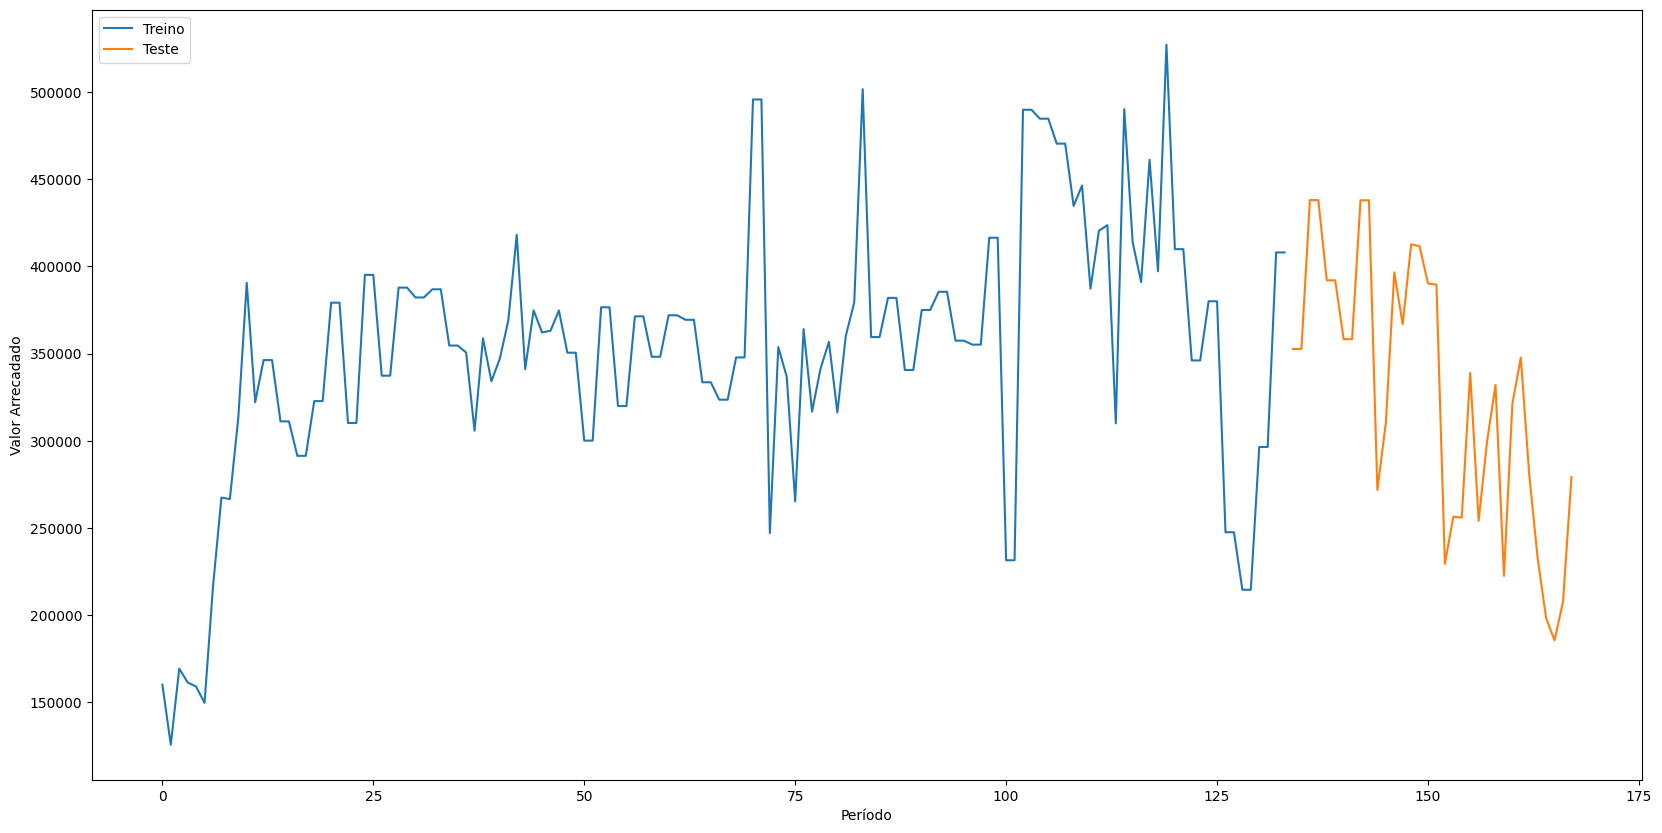

Dimension of train data:  (134, 16)
Dimension of test data:  (34, 16)


<Figure size 640x480 with 0 Axes>

In [36]:
plot_series_data(df_receitas_agrupado, 'valor_receita')

### Modelagem dos dados

In [69]:
train_size = int(len(df_receitas_agrupado) * 0.75)
train_dataset, test_dataset = df_receitas_agrupado.iloc[:train_size], df_receitas_agrupado.iloc[train_size:]

In [70]:
X_train = train_dataset.drop(['valor_receita'], axis=1)
y_train = train_dataset.loc[:, ['valor_receita']]

In [71]:
X_test = test_dataset.drop(['valor_receita'], axis=1)
y_test = test_dataset.loc[:, ['valor_receita']]

In [72]:
from sklearn.preprocessing import MinMaxScaler

scaler_x = MinMaxScaler(feature_range=(0,1))
scaler_y = MinMaxScaler(feature_range=(0,1))

In [73]:
input_scaler = scaler_x.fit(X_train)
output_scaler = scaler_y.fit(y_train)

In [74]:
# normalizando os dados de treino e teste
train_y_norm = output_scaler.transform(y_train)
train_x_norm = input_scaler.transform(X_train)

test_y_norm = output_scaler.transform(y_test)
test_x_norm = input_scaler.transform(X_test)

In [75]:
X_test = test_x_norm.reshape((test_x_norm.shape[0], 1, test_x_norm.shape[1]))
X_train = train_x_norm.reshape((train_x_norm.shape[0], 1, train_x_norm.shape[1]))
y_test = test_y_norm.reshape((test_y_norm.shape[0], 1))
y_train = train_y_norm.reshape((train_y_norm.shape[0], 1))

Ajuste no modelo com 32, 64 e 128 neurônios para verficação do mais adequado para a aplicação.

Epoch 1/100
25/25 [==============================] - 9s 89ms/step - loss: 0.2211 - val_loss: 0.2270
Epoch 2/100
25/25 [==============================] - 0s 9ms/step - loss: 0.0423 - val_loss: 0.0329
Epoch 3/100
25/25 [==============================] - 0s 8ms/step - loss: 0.0179 - val_loss: 0.0399
Epoch 4/100
25/25 [==============================] - 0s 7ms/step - loss: 0.0142 - val_loss: 0.0345
Epoch 5/100
25/25 [==============================] - 0s 8ms/step - loss: 0.0156 - val_loss: 0.0357
Epoch 6/100
25/25 [==============================] - 0s 7ms/step - loss: 0.0152 - val_loss: 0.0360
Epoch 7/100
25/25 [==============================] - 0s 7ms/step - loss: 0.0133 - val_loss: 0.0348
Epoch 8/100
25/25 [==============================] - 0s 9ms/step - loss: 0.0144 - val_loss: 0.0343
Epoch 9/100
25/25 [==============================] - 0s 7ms/step - loss: 0.0126 - val_loss: 0.0329
Epoch 10/100
25/25 [==============================] - 0s 7ms/step - loss: 0.0129 - val_loss: 0.0341
Epoch 11

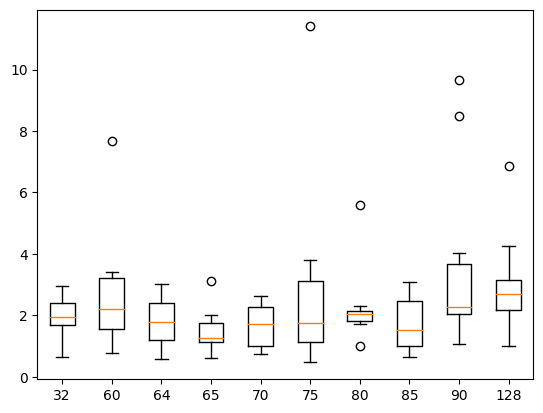

In [44]:
# Ajustando e validando o modelo
def evaluate_model(X_train, y_train, X_test, y_test, neurons):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.LSTM(units = neurons, return_sequences = True, input_shape = (X_train.shape[1], X_train.shape[2])))
    model.add(tf.keras.layers.Dropout(0.1))
    model.add(tf.keras.layers.LSTM(units = neurons))
    model.add(tf.keras.layers.Dropout(0.1))
    model.add(tf.keras.layers.Dense(units = 1))
    # compilando o modelo
    model.compile(loss='mse', optimizer='adam')
    # ajustando o modelo
    model.fit(X_train, y_train, epochs=100, batch_size=4, validation_split = 0.2, shuffle=False)
    # avaliando o modelo
    loss = model.evaluate(X_test, y_test, verbose=0, batch_size=4)
    return loss

# Resumindo as pontuações
def summarize_results(scores, params):
    print(scores, params)
    # resumindo a média e desvio padrão
    for i in range(len(scores)):
        m, s = np.mean(scores[i]), np.std(scores[i])
        print(f'Param={params[i]}, Mean={m:.3f}, Std={s:.3f}')
    # boxplot das pontuações
    plt.boxplot(scores, labels=params)
    plt.savefig('../../src/static/images/figura[0].png')

# Rodando um experimento
def run_experiment(params, repeats = 10):
    # Testando cada parâmetro
    all_scores = list()
    for p in params:
        # repetindo o experimento
        scores = list()
        for r in range(repeats):
            score = evaluate_model(X_train, y_train, X_test, y_test, p)
            score = score * 100.0
            scores.append(score)
            print(f'>Neurons={p}, Score={score}')
        all_scores.append(scores)
    # resumindo os resultados
    summarize_results(all_scores, params)

# Rodando o experimento
n_params = [32, 60, 64, 65, 70, 75, 80, 85, 90, 128]
run_experiment(n_params)

Ajuste de modelo com tamanho do lote 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11 e 12, para verificação do mais adequado para a aplicação.

Epoch 1/50
100/100 [==============================] - 12s 32ms/step - loss: 0.0416 - val_loss: 0.0319
Epoch 2/50
100/100 [==============================] - 1s 9ms/step - loss: 0.0163 - val_loss: 0.0311
Epoch 3/50
100/100 [==============================] - 1s 8ms/step - loss: 0.0128 - val_loss: 0.0312
Epoch 4/50
100/100 [==============================] - 1s 9ms/step - loss: 0.0123 - val_loss: 0.0329
Epoch 5/50
100/100 [==============================] - 1s 8ms/step - loss: 0.0121 - val_loss: 0.0301
Epoch 6/50
100/100 [==============================] - 1s 8ms/step - loss: 0.0119 - val_loss: 0.0279
Epoch 7/50
100/100 [==============================] - 1s 9ms/step - loss: 0.0111 - val_loss: 0.0261
Epoch 8/50
100/100 [==============================] - 1s 8ms/step - loss: 0.0101 - val_loss: 0.0275
Epoch 9/50
100/100 [==============================] - 1s 8ms/step - loss: 0.0099 - val_loss: 0.0259
Epoch 10/50
100/100 [==============================] - 1s 9ms/step - loss: 0.0105 - val_loss: 0.02

100/100 [==============================] - 1s 8ms/step - loss: 0.0080 - val_loss: 0.0182
Epoch 19/50
100/100 [==============================] - 1s 7ms/step - loss: 0.0067 - val_loss: 0.0196
Epoch 20/50
100/100 [==============================] - 1s 7ms/step - loss: 0.0074 - val_loss: 0.0176
Epoch 21/50
100/100 [==============================] - 1s 6ms/step - loss: 0.0076 - val_loss: 0.0233
Epoch 22/50
100/100 [==============================] - 1s 6ms/step - loss: 0.0058 - val_loss: 0.0186
Epoch 23/50
100/100 [==============================] - 1s 6ms/step - loss: 0.0063 - val_loss: 0.0169
Epoch 24/50
100/100 [==============================] - 1s 6ms/step - loss: 0.0095 - val_loss: 0.0180
Epoch 25/50
100/100 [==============================] - 1s 6ms/step - loss: 0.0059 - val_loss: 0.0163
Epoch 26/50
100/100 [==============================] - 1s 6ms/step - loss: 0.0060 - val_loss: 0.0131
Epoch 27/50
100/100 [==============================] - 1s 6ms/step - loss: 0.0065 - val_loss: 0.0205
Ep

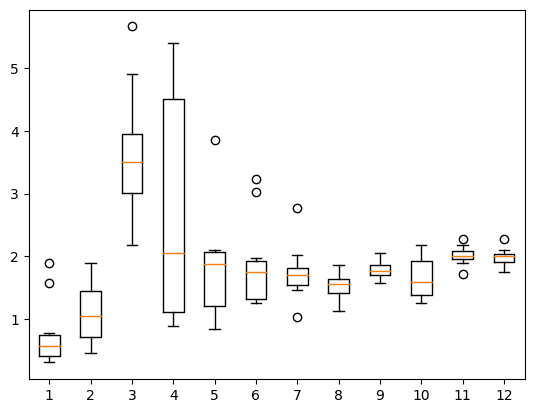

In [45]:
# Ajustando e validando o modelo
def evaluate_model(X_train, y_train, X_test, y_test, batch_size):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.LSTM(units = 80, return_sequences = True, input_shape = (X_train.shape[1], X_train.shape[2])))
    model.add(tf.keras.layers.Dropout(0.1))
    model.add(tf.keras.layers.LSTM(units = 80))
    model.add(tf.keras.layers.Dropout(0.1))
    model.add(tf.keras.layers.Dense(units = 1))
    # compilando o modelo
    model.compile(loss='mse', optimizer='adam')
    # ajustando o modelo
    model.fit(X_train, y_train, epochs=50, batch_size=batch_size, validation_split = 0.2, shuffle=False)
    # avaliando o modelo
    loss = model.evaluate(X_test, y_test, verbose=0, batch_size=batch_size)
    return loss

# Resumindo as pontuações
def summarize_results(scores, params):
    print(scores, params)
    # resumindo a média e desvio padrão
    for i in range(len(scores)):
        m, s = np.mean(scores[i]), np.std(scores[i])
        print(f'Param={params[i]}, Mean={m:.3f}, Std={s:.3f}')
    # boxplot das pontuações
    plt.boxplot(scores, labels=params)
    plt.savefig('../../src/static/images/figura[1].png')

# Rodando um experimento
def run_experiment(params, repeats = 10):
    # Testando cada parâmetro
    all_scores = list()
    for p in params:
        # repetindo o experimento
        scores = list()
        for r in range(repeats):
            score = evaluate_model(X_train, y_train, X_test, y_test, p)
            score = score * 100.0
            scores.append(score)
            print(f'>p={p}: {r+1}, Score={score}')
        all_scores.append(scores)
    # resumindo os resultados
    summarize_results(all_scores, params)

# Rodando o experimento
n_params = np.arange(1, 13)
run_experiment(n_params)

Ajuste no modelo com diluição - dropout - 0.05, 0.1, 0.2, 0.3, para verficação do mais adequado para a aplicação.

Epoch 1/50
20/20 [==============================] - 6s 67ms/step - loss: 0.1610 - val_loss: 0.0644
Epoch 2/50
20/20 [==============================] - 0s 7ms/step - loss: 0.0227 - val_loss: 0.0415
Epoch 3/50
20/20 [==============================] - 0s 7ms/step - loss: 0.0162 - val_loss: 0.0333
Epoch 4/50
20/20 [==============================] - 0s 7ms/step - loss: 0.0128 - val_loss: 0.0361
Epoch 5/50
20/20 [==============================] - 0s 8ms/step - loss: 0.0112 - val_loss: 0.0336
Epoch 6/50
20/20 [==============================] - 0s 7ms/step - loss: 0.0112 - val_loss: 0.0347
Epoch 7/50
20/20 [==============================] - 0s 8ms/step - loss: 0.0109 - val_loss: 0.0334
Epoch 8/50
20/20 [==============================] - 0s 7ms/step - loss: 0.0107 - val_loss: 0.0325
Epoch 9/50
20/20 [==============================] - 0s 7ms/step - loss: 0.0103 - val_loss: 0.0328
Epoch 10/50
20/20 [==============================] - 0s 7ms/step - loss: 0.0100 - val_loss: 0.0334
Epoch 11/50
20/20 

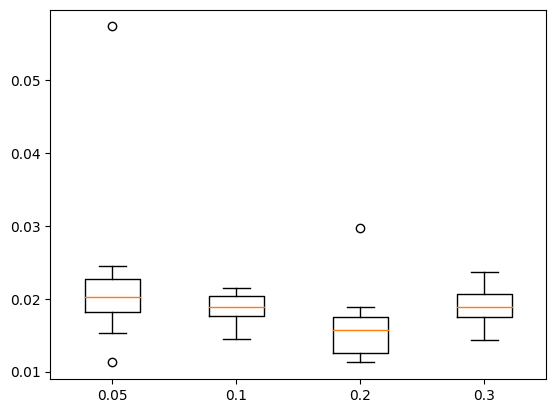

In [46]:
# Ajustando e validando o modelo
def evaluate_model(X_train, y_train, X_test, y_test, dropout):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.LSTM(units = 80, return_sequences = True, input_shape = (X_train.shape[1], X_train.shape[2])))
    model.add(tf.keras.layers.Dropout(dropout))
    model.add(tf.keras.layers.LSTM(units = 80))
    model.add(tf.keras.layers.Dropout(dropout))
    model.add(tf.keras.layers.Dense(units = 1))
    # compilando o modelo
    model.compile(loss='mse', optimizer='adam')
    # ajustando o modelo
    model.fit(X_train, y_train, epochs=50, batch_size=5, validation_split = 0.2, shuffle=False)
    # avaliando o modelo
    loss = model.evaluate(X_test, y_test, verbose=0, batch_size=5)
    return loss

# Resumindo as pontuações
def summarize_results(scores, params):
    print(scores, params)
    # resumindo a média e desvio padrão
    for i in range(len(scores)):
        m, s = np.mean(scores[i]), np.std(scores[i])
        print(f'Param={params[i]}, Mean={m:.3f}:, Std={s:.3f}')
    # boxplot das pontuações
    plt.boxplot(scores, labels=params)
    plt.savefig('../../src/static/images/figura[2].png')

# Rodando um experimento
def run_experiment(params, repeats = 10):
    # Testando cada parâmetro
    all_scores = list()
    for p in params:
        # repetindo o experimento
        scores = list()
        for r in range(repeats):
            score = evaluate_model(X_train, y_train, X_test, y_test, p)
            score = score
            scores.append(score)
            print(f'>p={p}: {r+1}, Score={score}')
        all_scores.append(scores)
    # resumindo os resultados
    summarize_results(all_scores, params)

# Rodando o experimento
n_params = [0.05, 0.1, 0.2, 0.3]
run_experiment(n_params)

Ajustando o modelo com os padrões mais adequados visualizados nos testes anteriores.
<p>Neurônios = 128</p>
<p>Tamanho do lote/batch = 10</p>
<p>Dopout = 0.05</p>

In [76]:
# Ajustando e validando o modelo
def evaluate_model(X_train, y_train, X_test, y_test):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.LSTM(units = 128, return_sequences = True, input_shape = (X_train.shape[1], X_train.shape[2])))
    model.add(tf.keras.layers.Dropout(0.1))
    model.add(tf.keras.layers.LSTM(units = 128))
    model.add(tf.keras.layers.Dropout(0.05))
    model.add(tf.keras.layers.Dense(units = 1))
    # compilando o modelo
    model.compile(loss='mse', optimizer='adam')
    # ajustando o modelo
    model.fit(X_train, y_train, epochs=150, batch_size=10, validation_split = 0.2, shuffle=False)
    # avaliando o modelo
    loss = model.evaluate(X_test, y_test, verbose=0, batch_size=5)
    return loss

# Resumindo as pontuações
def summarize_results(scores):
    print(scores)
    m, s = np.mean(scores), np.std(scores)
    print(f'Loss: Mean = {m:.3f}, Std = {s:.3f}')

# Rodando um experimento
def run_experiment(repeats = 10):
    # repetindo o experimento
    scores = list()
    for r in range(repeats):
        score = evaluate_model(X_train, y_train, X_test, y_test)
        score = score
        scores.append(score)
        print(f'>{r+1}: Score={score}')
    # resumindo os resultados
    summarize_results(scores)

# Rodando o experimento
run_experiment()

Epoch 1/150
10/10 [==============================] - 16s 426ms/step - loss: 0.2070 - val_loss: 0.1909
Epoch 2/150
10/10 [==============================] - 0s 27ms/step - loss: 0.0302 - val_loss: 0.0486
Epoch 3/150
10/10 [==============================] - 0s 26ms/step - loss: 0.0277 - val_loss: 0.0345
Epoch 4/150
10/10 [==============================] - 0s 28ms/step - loss: 0.0167 - val_loss: 0.0480
Epoch 5/150
10/10 [==============================] - 0s 31ms/step - loss: 0.0121 - val_loss: 0.0309
Epoch 6/150
10/10 [==============================] - 0s 36ms/step - loss: 0.0121 - val_loss: 0.0327
Epoch 7/150
10/10 [==============================] - 0s 30ms/step - loss: 0.0118 - val_loss: 0.0340
Epoch 8/150
10/10 [==============================] - 0s 28ms/step - loss: 0.0108 - val_loss: 0.0309
Epoch 9/150
10/10 [==============================] - 0s 37ms/step - loss: 0.0099 - val_loss: 0.0318
Epoch 10/150
10/10 [==============================] - 0s 26ms/step - loss: 0.0103 - val_loss: 0.03

### Criando modelo

In [77]:
def create_model(units, dropout):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.LSTM(units=units, return_sequences = True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(tf.keras.layers.Dropout(dropout))
    model.add(tf.keras.layers.LSTM(units = units))
    model.add(tf.keras.layers.Dropout(dropout))
    model.add(tf.keras.layers.Dense(units = 1))
    # compilando o modelo
    model.compile(loss='mse', optimizer='adam')
    return model

In [78]:
def fit_model(model):
    early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
    history = model.fit(X_train, y_train, epochs=150, batch_size=10, validation_split = 0.2, shuffle=False, callbacks=[early_stop])
    return history

In [79]:
model_lstm = create_model(128, 0.05)

### Salvando modelo:

In [80]:
model_lstm.save('receitas_2013_2022')

INFO:tensorflow:Assets written to: receitas_2013_2022\assets


INFO:tensorflow:Assets written to: receitas_2013_2022\assets


### Carga do modelo salvo:

In [81]:
model_lstm = tf.keras.models.load_model('receitas_2013_2022')

Pré-processamento e predição da base de testes com a utilização do modelo carregado:

In [82]:
def prediction(model):
    y_pred = model.predict(X_test)
    y_pred = scaler_y.inverse_transform(y_pred)
    return y_pred

In [83]:
def plot_future(prediction, y_test):
    plt.figure(figsize=(10,6))
    range_future = len(prediction)
    plt.plot(np.arange(range_future), np.array(y_test), label='Dados reais')
    plt.plot(np.arange(range_future), np.array(prediction),label='Predição')
    plt.legend(loc='upper left')
    plt.xlabel('Período')
    plt.ylabel('Valor Arrecadado')
    plt.title('Predição de Receitas - LSTM')
    plt.savefig('../../src/static/images/figura[3].png')
    plt.show()

In [84]:
y_test = scaler_y.inverse_transform(y_test)
y_train = scaler_y.inverse_transform(y_train)

prediction_lstm = prediction(model_lstm)

2/2 [==============================] - 2s 9ms/step


In [85]:
y_test

array([[247518.15],
       [247518.15],
       [214520.98],
       [214520.98],
       [296443.8 ],
       [296443.8 ],
       [408034.25],
       [408034.25],
       [352671.9 ],
       [352671.9 ],
       [438051.07],
       [438051.07],
       [392038.1 ],
       [392038.1 ],
       [358262.5 ],
       [358262.5 ],
       [437944.42],
       [437944.42],
       [271734.79],
       [310211.35],
       [396586.74],
       [366820.74],
       [412721.25],
       [411594.34],
       [390231.34],
       [389543.34],
       [229352.56],
       [256427.29],
       [255933.3 ],
       [339005.83],
       [254040.03],
       [299705.63],
       [332093.74],
       [222432.57],
       [321259.43],
       [347717.77],
       [280317.33],
       [232355.13],
       [198234.65],
       [185469.57],
       [207671.22],
       [279195.09]])

In [86]:
prediction_lstm

array([[130857.484],
       [131874.53 ],
       [130666.21 ],
       [131634.98 ],
       [130632.7  ],
       [131266.5  ],
       [130862.516],
       [131443.62 ],
       [131116.05 ],
       [131969.4  ],
       [131048.19 ],
       [131812.19 ],
       [131196.95 ],
       [132060.38 ],
       [131193.75 ],
       [132183.33 ],
       [131115.17 ],
       [131835.69 ],
       [132333.94 ],
       [132569.05 ],
       [132156.98 ],
       [132282.2  ],
       [132343.72 ],
       [132141.98 ],
       [132557.56 ],
       [132535.44 ],
       [132458.67 ],
       [132774.08 ],
       [132125.55 ],
       [132366.83 ],
       [133448.64 ],
       [133872.69 ],
       [133532.94 ],
       [133793.95 ],
       [133961.58 ],
       [133431.81 ],
       [133923.95 ],
       [133885.56 ],
       [133912.45 ],
       [133978.08 ],
       [133807.66 ],
       [133662.16 ]], dtype=float32)

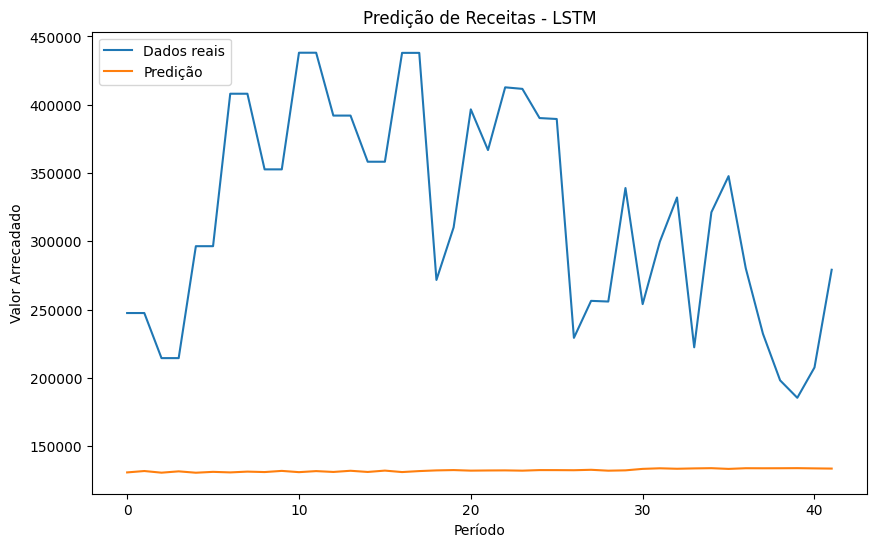

In [87]:
plot_future(prediction_lstm, y_test)

Cálculo do erro médio absoluto e raiz quadrática média:

In [88]:
def evaluate_prediction(prediction_lstm, actual, model_name):
    errors = prediction_lstm - actual
    mse = np.square(errors).mean()
    rmse = np.sqrt(mse)
    mae = np.abs(errors).mean()
    print(f'{model_name}:')
    print(f'MSE: {mse:.2f}, RMSE: {rmse:.2f}, MAE: {mae:.2f}')

In [89]:
evaluate_prediction(prediction_lstm, y_test, 'LSTM')

LSTM:
MSE: 41514790870.05, RMSE: 203751.79, MAE: 188642.82


Pré-processamento dos dados e aplicação do modelo em toda a base de dados (treino + teste):

In [90]:
def prediction(model):
    y_pred = model.predict(X)
    y_pred = scaler_y.inverse_transform(y_pred)
    return y_pred

In [91]:
def plot_future(prediction, y):
    plt.figure(figsize=(10,6))
    range_future = len(prediction)
    plt.plot(np.arange(range_future), np.array(y), label='Dados reais')
    plt.plot(np.arange(range_future), np.array(prediction),label='Predição')
    plt.legend(loc='upper left')
    plt.xlabel('Período')
    plt.ylabel('Valor Arrecadado')
    plt.title('Predição de Receitas - LSTM')
    plt.savefig('../../src/static/images/figura[4].png')
    plt.show()

6/6 [==============================] - 0s 10ms/step


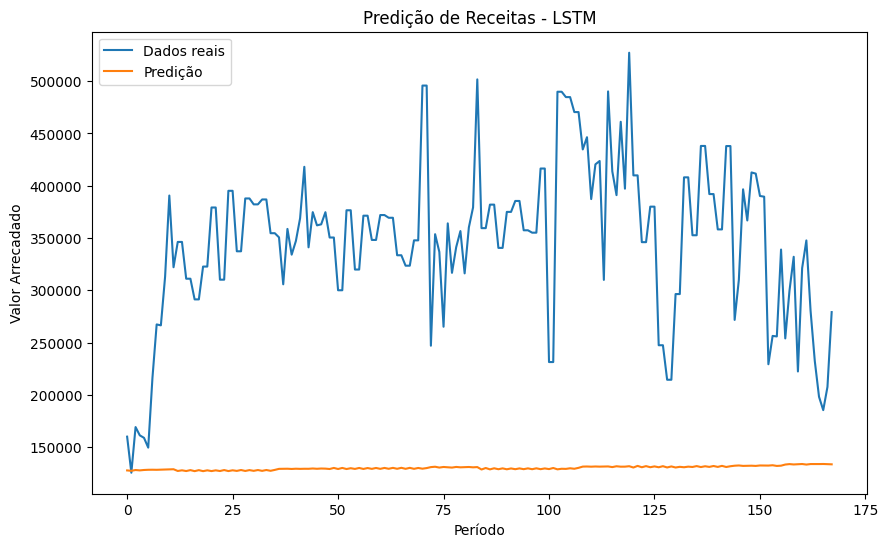

In [92]:
X = df_receitas_agrupado.drop(['valor_receita'], axis=1)
y = df_receitas_agrupado.loc[:, ['valor_receita']]

y_norm = output_scaler.transform(y)
X_norm = input_scaler.transform(X)

X = X_norm.reshape((X_norm.shape[0], 1, X_norm.shape[1]))
y = y_norm.reshape((y_norm.shape[0], 1))

y = scaler_y.inverse_transform(y)

prediction_lstm = prediction(model_lstm)

plot_future(prediction_lstm, y)

Cálculo do erro médio percentual:

In [93]:
real = y.flatten()
previsto = prediction_lstm.flatten()

tabela = pd.DataFrame([real, previsto]).T
tabela = tabela.rename(columns={0: 'Real', 1: 'Previsto'})
tabela['Diferenca'] = 1 - (tabela['Real'] / tabela['Previsto'])
media_tabela = tabela['Diferenca'].mean() * 100
print(f'Erro médio percentual: {media_tabela:.2f}%')

Erro médio percentual: -166.67%


Distribuição de erros:

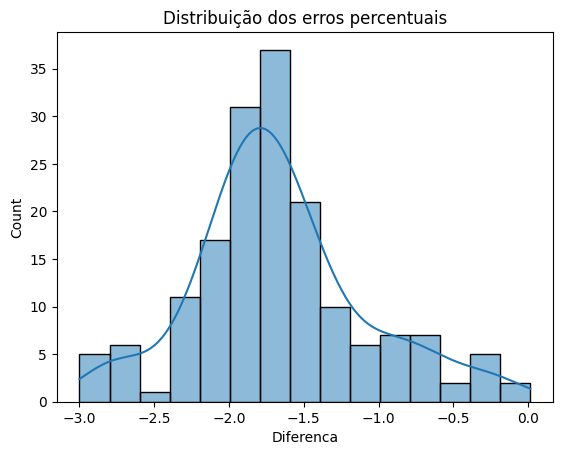

In [94]:
import seaborn as sns

sns.histplot(data=tabela, x='Diferenca', kde=True).set_title('Distribuição dos erros percentuais').get_figure().savefig('../../src/static/images/figura[5].png')

Relizando previsões com os dados e modelo treinado

In [95]:
previsao = df_receitas_agrupado

previsao

,valor_receita,populacao,variacao_anual,aceleracao_variacao_anual,valor_pib,SMA(12),SMA(6),SMA(3),SMA(2),lag(12),lag(6),lag(4),lag(3),lag(2),lag(1),ano_mes_ordinal
0,160122.33,60612,1482,1146,7.703390e+05,0.000000,0.000000,0.000000,0.000,0.00,0.00,0.00,0.00,0.00,0.00,734869
1,125630.52,60612,1482,1146,7.703390e+05,0.000000,0.000000,0.000000,142876.425,0.00,0.00,0.00,0.00,0.00,160122.33,734900
2,169281.06,60612,1482,1146,7.703390e+05,0.000000,0.000000,151677.970000,147455.790,0.00,0.00,0.00,0.00,160122.33,125630.52,734928
3,161371.68,60612,1482,1146,7.703390e+05,0.000000,0.000000,152094.420000,165326.370,0.00,0.00,0.00,160122.33,125630.52,169281.06,734959
4,158982.66,60612,1482,1146,7.703390e+05,0.000000,0.000000,163211.800000,160177.170,0.00,0.00,160122.33,125630.52,169281.06,161371.68,734989
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,232355.13,63239,663,376,1.393869e+06,280886.717500,289362.661667,286796.743333,256336.230,389543.34,299705.63,222432.57,321259.43,347717.77,280317.33,738368
164,198234.65,63239,663,376,1.393869e+06,278293.558333,267052.813333,236969.036667,215294.890,229352.56,332093.74,321259.43,347717.77,280317.33,232355.13,738399
165,185469.57,63239,663,376,1.393869e+06,272380.415000,260892.313333,205353.116667,191852.110,256427.29,222432.57,347717.77,280317.33,232355.13,198234.65,738429
166,207671.22,63239,663,376,1.393869e+06,268358.575000,241960.945000,197125.146667,196570.395,255933.30,321259.43,280317.33,232355.13,198234.65,185469.57,738460


In [96]:
periodo = 8  # escolha o período de previsão à frente será executado

for i in range(periodo):
    # Crie uma nova linha de dados vazia
    row = pd.DataFrame(columns=previsao.columns)

    # Calcule as médias e valores de atraso
    row.loc[0, 'SMA(12)'] = previsao['valor_receita'].iloc[-12:].mean()
    row.loc[0, 'SMA(6)'] = previsao['valor_receita'].iloc[-6:].mean()
    row.loc[0, 'SMA(3)'] = previsao['valor_receita'].iloc[-3:].mean()
    row.loc[0, 'SMA(2)'] = previsao['valor_receita'].iloc[-2:].mean()
    row.loc[0, 'lag(12)'] = previsao['valor_receita'].iloc[-12]
    row.loc[0, 'lag(6)'] = previsao['valor_receita'].iloc[-6]
    row.loc[0, 'lag(4)'] = previsao['valor_receita'].iloc[-4]
    row.loc[0, 'lag(3)'] = previsao['valor_receita'].iloc[-3]
    row.loc[0, 'lag(2)'] = previsao['valor_receita'].iloc[-2]
    row.loc[0, 'lag(1)'] = previsao['valor_receita'].iloc[-1]

    # Incremente a data
    row.loc[0, 'ano_mes_ordinal'] = previsao['ano_mes_ordinal'].iloc[-1]+1
    
    # Excluindo a coluna de valor arrecadado
    row = row.drop(['valor_receita'], axis=1)
    
    # Transforme a linha em um array e normalize
    row = np.array(row.iloc[-1]).reshape(1, -1)
    row_norm = input_scaler.transform(row)

    # Preveja usando o modelo LSTM
    to_prev = row_norm.reshape((row_norm.shape[0], 1, row_norm.shape[1]))
    prev = model_lstm.predict(to_prev)
    prev = scaler_y.inverse_transform(prev)

    # Crie um DataFrame com a previsão e adicione ao DataFrame principal
    row_ = pd.DataFrame(row, columns = ['ano_mes_ordinal', 'SMA(12)', 'SMA(6)', 'SMA(3)', 'SMA(2)', 'lag(12)', 'lag(6)', 'lag(4)', 'lag(3)', 'lag(2)', 'lag(1)', 'populacao', 'variacao_anual', 'aceleracao_variacao_anual', 'valor_pib'])
    row_.loc[0, 'valor_receita'] = prev[0]
    previsao = pd.concat([previsao, row_], ignore_index=True)

previsao

1/1 [==============================] - ETA: 0s

c:\Users\allys\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 68ms/step


1/1 [==============================] - 0s 51ms/step


c:\Users\allys\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\allys\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 51ms/step


c:\Users\allys\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\allys\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 51ms/step


c:\Users\allys\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\allys\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 53ms/step


c:\Users\allys\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


,valor_receita,populacao,variacao_anual,aceleracao_variacao_anual,valor_pib,SMA(12),SMA(6),SMA(3),SMA(2),lag(12),lag(6),lag(4),lag(3),lag(2),lag(1),ano_mes_ordinal
0,160122.33,60612,1482,1146,770339.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,734869
1,125630.52,60612,1482,1146,770339.0,0.0,0.0,0.00,142876.425,0.0,0.0,0.0,0.0,0.0,160122.33,734900
2,169281.06,60612,1482,1146,770339.0,0.0,0.0,151677.97,147455.79,0.0,0.0,0.0,0.0,160122.33,125630.52,734928
3,161371.68,60612,1482,1146,770339.0,0.0,0.0,152094.42,165326.37,0.0,0.0,0.0,160122.33,125630.52,169281.06,734959
4,158982.66,60612,1482,1146,770339.0,0.0,0.0,163211.80,160177.17,0.0,0.0,160122.33,125630.52,169281.06,161371.68,734989
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,252739.195556,224111.96,NaN,NaN,222432.57,185469.57,279195.09,NaN
172,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,256527.52375,243433.155,NaN,NaN,321259.43,207671.22,NaN,NaN
173,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,247280.108571,279195.09,NaN,NaN,347717.77,279195.09,NaN,NaN
174,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,230540.498333,NaN,NaN,NaN,280317.33,NaN,NaN,NaN
